In [1]:
print("hello");

hello


In [2]:
import pandas

In [3]:
import pm4py
from pm4py.objects.conversion.log import converter as log_converter 
from pm4py.objects.log.importer.xes import importer as xes_importer

In [4]:
event_log = pandas.read_csv("ArtificialPatientTreatment.csv" , sep=',')

In [5]:
print(len(event_log))

690


In [6]:
print(event_log.columns)

Index(['patient', ' action', ' org:resource', ' DateTime'], dtype='object')


In [7]:
       #event_log.drop('costs' , axis=1)
event_log.style

,patient,action,org:resource,DateTime
0,0,First consult,Dr. Anna,2017-01-02 11:40:11
1,0,Blood test,Lab,2017-01-02 12:47:33
2,0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,0,Surgery,Dr. Charlie,2017-01-05 13:23:09
5,0,Final consult,Dr. Ben,2017-01-09 08:29:28
6,1,First consult,Dr. Anna,2017-01-02 12:50:35
7,1,Physical test,Nurse Jesse,2017-01-02 13:59:14
8,1,Blood test,Lab,2017-01-02 14:20:19
9,1,X-ray scan,Team 1,2017-01-06 09:13:40


In [8]:
event_log.rename(columns={' DateTime': 'time:timestamp', 
'patient': 'case:concept:name', ' action': 'concept:name', ' org:resource': 'org:resource'}, inplace=True)


In [9]:
event_log.style

,case:concept:name,concept:name,org:resource,time:timestamp
0,0,First consult,Dr. Anna,2017-01-02 11:40:11
1,0,Blood test,Lab,2017-01-02 12:47:33
2,0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,0,Surgery,Dr. Charlie,2017-01-05 13:23:09
5,0,Final consult,Dr. Ben,2017-01-09 08:29:28
6,1,First consult,Dr. Anna,2017-01-02 12:50:35
7,1,Physical test,Nurse Jesse,2017-01-02 13:59:14
8,1,Blood test,Lab,2017-01-02 14:20:19
9,1,X-ray scan,Team 1,2017-01-06 09:13:40


In [10]:
log = log_converter.apply(event_log)

In [11]:
#event_log = event_log.drop('costs' , axis=1)
print(event_log.columns)

Index(['case:concept:name', 'concept:name', 'org:resource', 'time:timestamp'], dtype='object')


In [12]:
from pm4py.objects.conversion.log import converter as log_converter
log = log_converter.apply(event_log)

In [13]:
## Import the alpha_miner algorithm
import pm4py
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(log)

In [14]:
print(log)

[{'attributes': {'concept:name': 0}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Anna', 'time:timestamp': ' 2017-01-02 11:40:11'}, '..', {'concept:name': ' Final consult', 'org:resource': ' Dr. Ben', 'time:timestamp': ' 2017-01-09 08:29:28'}]}, '....', {'attributes': {'concept:name': 99}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Bob', 'time:timestamp': ' 2017-05-18 11:57:11'}, '..', {'concept:name': ' Final consult', 'org:resource': ' Dr. Anna', 'time:timestamp': ' 2017-05-31 12:46:43'}]}]


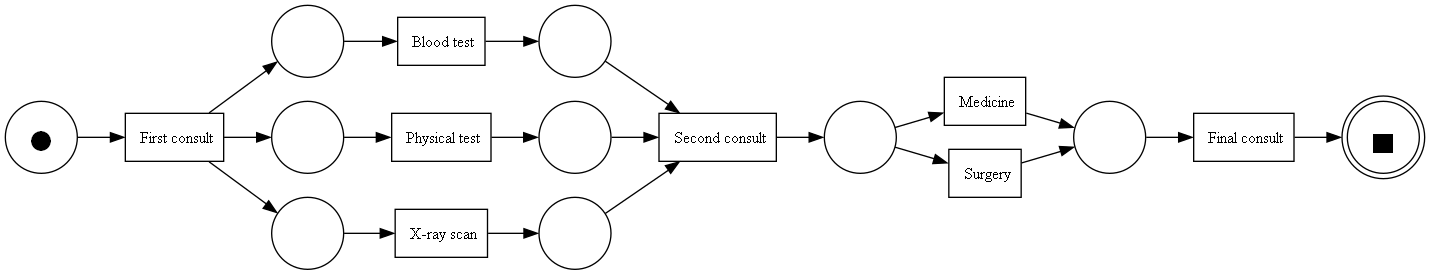

In [15]:
## Import the petrinet visualizer object
from pm4py.visualization.petri_net import visualizer as pn_visualizer
# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

In [16]:
print(net)

places: [ ({' Blood test'}, {' Second consult'}), ({' First consult'}, {' Blood test'}), ({' First consult'}, {' Physical test'}), ({' First consult'}, {' X-ray scan'}), ({' Medicine', ' Surgery'}, {' Final consult'}), ({' Physical test'}, {' Second consult'}), ({' Second consult'}, {' Medicine', ' Surgery'}), ({' X-ray scan'}, {' Second consult'}), end, start ]
transitions: [ ( Blood test, ' Blood test'), ( Final consult, ' Final consult'), ( First consult, ' First consult'), ( Medicine, ' Medicine'), ( Physical test, ' Physical test'), ( Second consult, ' Second consult'), ( Surgery, ' Surgery'), ( X-ray scan, ' X-ray scan') ]
arcs: [ ( Blood test, ' Blood test')->({' Blood test'}, {' Second consult'}), ( Final consult, ' Final consult')->end, ( First consult, ' First consult')->({' First consult'}, {' Blood test'}), ( First consult, ' First consult')->({' First consult'}, {' Physical test'}), ( First consult, ' First consult')->({' First consult'}, {' X-ray scan'}), ( Medicine, ' Me

In [17]:
print(initial_marking)

['start:1']


In [18]:
print(final_marking)

['end:1']


In [19]:
print(type(net))

<class 'pm4py.objects.petri_net.obj.PetriNet'>


In [20]:
print(net.places)

{start, ({' First consult'}, {' Physical test'}), ({' Physical test'}, {' Second consult'}), end, ({' First consult'}, {' Blood test'}), ({' X-ray scan'}, {' Second consult'}), ({' Blood test'}, {' Second consult'}), ({' First consult'}, {' X-ray scan'}), ({' Second consult'}, {' Medicine', ' Surgery'}), ({' Medicine', ' Surgery'}, {' Final consult'})}


In [21]:
hasattr(net.places, 'start')

False

In [22]:
placesStr = str(net.places)

In [23]:
type(net.places)

set

In [24]:
if "start" in net.places:
    print("test")

In [25]:
res = [i for i in range(len(placesStr)) if placesStr.startswith(", {\' Second consult\'})" , i)]

In [26]:
print(res)

[69, 153, 193]


In [27]:
if len(res) > 1:
    print("lol")

lol


In [28]:
#This function does not check the different aspects of a net (reachability, boundedness or Liveness) it checks if the net conforms to the nature
#of the real data, technically the nets are sound but may not conform to the way the log is presented
def checkNet(places, event_log_IDs):
    #Lists for seperating first and second transitions, lists for duplicates, 
    #indices, after and before transitions and counters to determine petri net
    IDs = list(dict.fromkeys(event_log_IDs.tolist()))
    placesF = []
    dupF = []
    dupS = []
    indicesF = []
    indicesS = []
    afterF = []
    beforeS = []
    placesS = []
    countF = 0
    countS = 0
    for i in places:
        #Removing 'start' and 'end' places, segregating First and Second transitions using the curly and regular brackets as a partition point
        if(str(i).startswith("({")):
            placesF.append(str(i).partition('}')[0].replace("({'" , '').replace("'", '').strip())
            placesS.append(str(i).partition('}')[2].replace(", {'" , '').replace("'})", '').strip())
    # Creating a list of duplicates in each transition list to cross-reference with the original log (if there are duplicates in the transition list this means that 
    # a transition would split into multiple places or multiple places would converge on one transition depending on which list the duplicate is in)
    dupF = list({x for x in placesF if placesF.count(x) > 1})
    dupS = list({x for x in placesF if placesS.count(x) > 1})
    #Creating an indices list with the same indices as the first transition duplicates, this is because the index of the duplicate will be the same as the index
    #of the transition after the duplicate.
    for x in dupF:
        indicesF = [i for i in range(len(placesF)) if placesF[i] == x]
        for i in indicesF:
            for m in placesS:
                #Using the newly created index list to create a list of the transitions after the duplicate
                if i == placesS.index(m):
                    afterF.append(placesS[i])
        #looping through all case IDs, creating a temporary list of transitions (events) for each case
        for id in IDs:
            TFlist = []
            for index, case in event_log.loc[event_log['case:concept:name'] == id].iterrows():
                TFlist.append(case['concept:name'].strip())
            #Finally we check the list of transitions after the duplicate by comparing it the original data, we check it for each case
            #If one of the cases does not have one of the events (transitions) then the we increment the counter
            for after in afterF:
                if after not in TFlist:
                    countF = countF + 1
            #if the counter > 0 then there is a problem with the petri net
            if countF > 0:
                print(countF)
                print('Problem located after ' + x)
                break
    #Similar to the previous loop but for the next set of transitions, we check if the transitions before the duplicates are in every case
    for x in dupS:
        indicesS = [i for i in range(len(placesS)) if placesS[i] == x]
        for i in indicesS:
            for m in placesF:
                if i == placesF.index(m):
                    beforeS.append(placesF[i])
        for id in IDs:
            TSlist = []
            for index, case in event_log.loc[event_log['case:concept:name'] == id].iterrows():
                TSlist.append(case['concept:name'].strip())
            for before in beforeS:
                if before not in TSlist:
                    countS = countS + 1
            if countS > 0:
                print(countS)
                print('Problem located before ' + x)
                break

In [29]:
checkNet(net.places, event_log['case:concept:name'])

1
Problem located after First consult
1
Problem located before Second consult


In [30]:
from pm4py.algo.comparison.petrinet import element_usage_comparison as comparison

In [36]:
case = event_log.loc[event_log['case:concept:name'] == 0]
type(case)
logZ = log_converter.apply(case)
print(case)
netZ, initial_markingZ, final_markingZ = alpha_miner.apply(logZ)

   case:concept:name     concept:name  org:resource        time:timestamp
0                  0    First consult      Dr. Anna   2017-01-02 11:40:11
1                  0       Blood test           Lab   2017-01-02 12:47:33
2                  0    Physical test   Nurse Jesse   2017-01-02 12:53:50
3                  0   Second consult      Dr. Anna   2017-01-02 16:21:06
4                  0          Surgery   Dr. Charlie   2017-01-05 13:23:09
5                  0    Final consult       Dr. Ben   2017-01-09 08:29:28


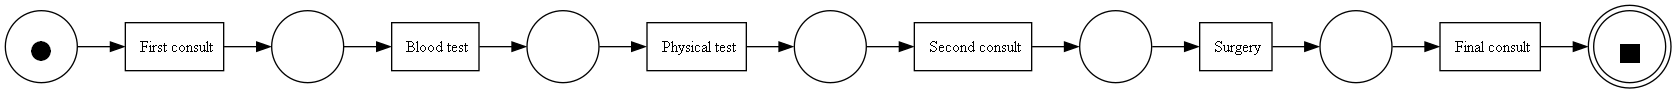

In [37]:
## Import the petrinet visualizer object
from pm4py.visualization.petri_net import visualizer as pn_visualizer
# Visualise 
gvizZ = pn_visualizer.apply(netZ, initial_markingZ, final_markingZ) 
pn_visualizer.view(gvizZ)

In [38]:
caseO = event_log.loc[event_log['case:concept:name'] == 1]
logO = log_converter.apply(caseO)
print(caseO)
netO, initial_markingO, final_markingO = alpha_miner.apply(logO)

    case:concept:name     concept:name  org:resource        time:timestamp
6                   1    First consult      Dr. Anna   2017-01-02 12:50:35
7                   1    Physical test   Nurse Jesse   2017-01-02 13:59:14
8                   1       Blood test           Lab   2017-01-02 14:20:19
9                   1       X-ray scan        Team 1   2017-01-06 09:13:40
10                  1   Second consult      Dr. Anna   2017-01-06 10:38:04
11                  1         Medicine      Pharmacy   2017-01-06 11:47:36
12                  1    Final consult      Dr. Anna   2017-01-06 16:49:21


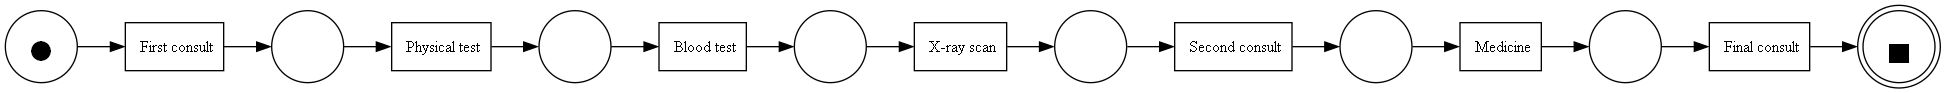

In [35]:
## Import the petrinet visualizer object
from pm4py.visualization.petri_net import visualizer as pn_visualizer
# Visualise 
gvizO = pn_visualizer.apply(netO, initial_markingO, final_markingO) 
pn_visualizer.view(gvizO)

In [40]:
caseT = event_log.loc[event_log['case:concept:name'] == 2]
logT = log_converter.apply(caseT)
print(caseT)
netT, initial_markingT, final_markingT = alpha_miner.apply(logT)

    case:concept:name     concept:name  org:resource        time:timestamp
13                  2    First consult      Dr. Anna   2017-01-04 10:02:49
14                  2    Physical test   Nurse Jesse   2017-01-06 09:05:01
15                  2       X-ray scan        Team 2   2017-01-10 08:05:47
16                  2       Blood test           Lab   2017-01-10 09:12:09
17                  2   Second consult      Dr. Anna   2017-01-12 16:32:00
18                  2         Medicine      Pharmacy   2017-01-13 10:32:51
19                  2    Final consult       Dr. Ben   2017-01-17 11:54:48


In [41]:
comp1 = comparison.compare_element_usage_two_logs(net, initial_marking, final_marking, logZ, logT)
print(comp1)

{({' Blood test'}, {' Second consult'}): {'log1_occ': 1, 'log2_occ': 1, 'total_occ': 2, 'label': '(1/1/2)', 'direction': 0.0, 'color': '#ACACAC'}, ({' Second consult'}, {' Medicine', ' Surgery'}): {'log1_occ': 1, 'log2_occ': 1, 'total_occ': 2, 'label': '(1/1/2)', 'direction': 0.0, 'color': '#ACACAC'}, ({' Medicine', ' Surgery'}, {' Final consult'}): {'log1_occ': 1, 'log2_occ': 1, 'total_occ': 2, 'label': '(1/1/2)', 'direction': 0.0, 'color': '#ACACAC'}, start: {'log1_occ': 1, 'log2_occ': 1, 'total_occ': 2, 'label': '(1/1/2)', 'direction': 0.0, 'color': '#ACACAC'}, ({' First consult'}, {' Physical test'}): {'log1_occ': 1, 'log2_occ': 1, 'total_occ': 2, 'label': '(1/1/2)', 'direction': 0.0, 'color': '#ACACAC'}, ({' Physical test'}, {' Second consult'}): {'log1_occ': 1, 'log2_occ': 1, 'total_occ': 2, 'label': '(1/1/2)', 'direction': 0.0, 'color': '#ACACAC'}, end: {'log1_occ': 1, 'log2_occ': 1, 'total_occ': 2, 'label': '(1/1/2)', 'direction': 0.0, 'color': '#ACACAC'}, ({' First consult'}, 

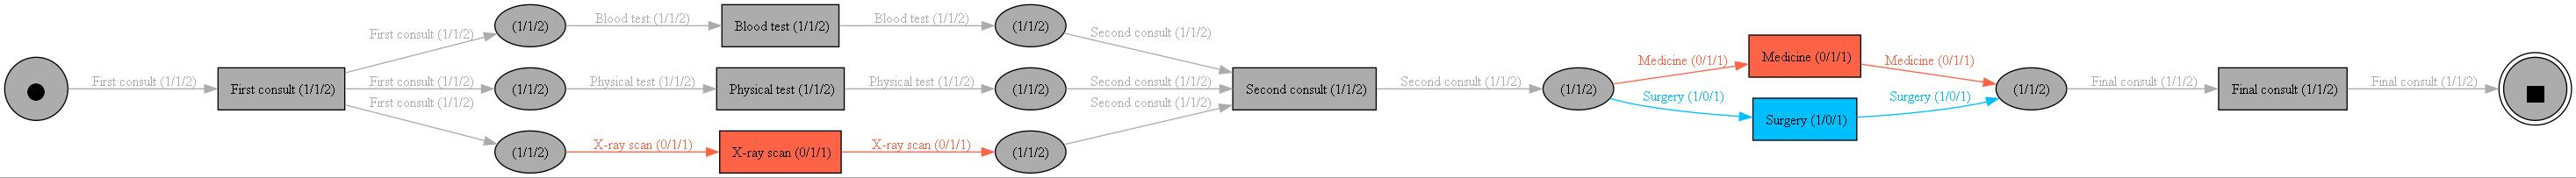

In [42]:
## Import the petrinet visualizer object
from pm4py.visualization.petri_net import visualizer as pn_visualizer
# Visualise 
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "jpg"}
gvizC = pn_visualizer.apply(net, initial_marking, final_marking, log={logZ,logT} , aggregated_statistics=comp1 , parameters=parameters,variant=pn_visualizer.Variants.FREQUENCY) 
pn_visualizer.view(gvizC)

In [43]:
print(event_log.columns)

Index(['case:concept:name', 'concept:name', 'org:resource', 'time:timestamp'], dtype='object')


In [44]:
from pm4py.objects.log.util import dataframe_utils
test = dataframe_utils.convert_timestamp_columns_in_df(event_log)
print(test)

     case:concept:name     concept:name  org:resource  \
0                    0    First consult      Dr. Anna   
1                    0       Blood test           Lab   
2                    0    Physical test   Nurse Jesse   
3                    0   Second consult      Dr. Anna   
4                    0          Surgery   Dr. Charlie   
..                 ...              ...           ...   
685                 99       X-ray scan        Team 2   
686                 99    Physical test   Nurse Corey   
687                 99   Second consult      Dr. Anna   
688                 99         Medicine      Pharmacy   
689                 99    Final consult      Dr. Anna   

               time:timestamp  
0   2017-01-02 11:40:11+00:00  
1   2017-01-02 12:47:33+00:00  
2   2017-01-02 12:53:50+00:00  
3   2017-01-02 16:21:06+00:00  
4   2017-01-05 13:23:09+00:00  
..                        ...  
685 2017-05-25 11:03:27+00:00  
686 2017-05-25 11:55:24+00:00  
687 2017-05-29 15:12:39+00:

C:\Users\Kareem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pm4py\objects\log\util\dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
C:\Users\Kareem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pm4py\objects\log\util\dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
